# OISST Timeseries - GMRI SST Focal Areas

**ABOUT:**
Timelines of temperature anomalies, their variance, and their likelihood for areas of special interest to GMRI.

## Product 4. OISST Regional Timeseries


**Objective: Calculate full sea surface temperature histories for the GMRI Focal Areas**

In [1]:
# Load Packages
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
import geopandas as gpd
import regionmask
import math

# Set the workspace - local/ docker
workspace = "local"

# Root paths
root_locations = {"local"  : "/Users/akemberling/Box/",
                  "docker" : "/home/jovyan/"}


# Set root
box_root = root_locations[workspace]
print(f"Working via {workspace} directory at: {box_root}")


#Suppress divide by NA error that occurs when getting mean from array
np.seterr(divide = 'ignore', invalid = 'ignore')

Working via local directory at: /Users/akemberling/Box/


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Step 1: Load Focal Areas

As a favor for myself I put the R code to generate the focal areas, as well as a description of their origins and uses within `R/GMRI_Temperature_Focus_Areas.R`

As of 12/8/2020 these include:
 * Andy Pershing's Gulf of Maine Bounding Box for SST Updates
 * The "Gulf of Maine" extent used for the continuous plankton recorder analysis
 * The Northwest Atlantic Region, useful for larger trends of Gulf of Maine as well as Labrador Sea

In [2]:
# Load gmri focal regions - created in R code,
focal_area_paths = {
    "APershing Gulf of Maine"   : f"{box_root}RES_Data/Shapefiles/gmri_sst_focal_areas/apershing_gulf_of_maine.geojson",
    "CPR Gulf of Maine"         : f"{box_root}RES_Data/Shapefiles/gmri_sst_focal_areas/cpr_gulf_of_maine.geojson",
    "Northwest Atlantic"        : f"{box_root}RES_Data/Shapefiles/gmri_sst_focal_areas/aak_northwest_atlantic.geojson"}

# Dictionary to path lookup table
focal_area_info = pd.DataFrame.from_dict(focal_area_paths, orient = "index", columns = ["path"])
focal_area_info = focal_area_info.reset_index().rename(columns = {"index": "area"})

# Load polygons
focal_areas = []
for i, area_path in focal_area_info.iterrows():
    shape = gpd.read_file(area_path.path)
    focal_areas.append(shape)

# Plot names
for area in focal_areas:
    print(area["area"])


0    Gulf of Maine
Name: area, dtype: object
0    CPR Gulf of Maine
Name: area, dtype: object
0    Northwest Atlantic
Name: area, dtype: object


## Step 2: Load OISST Collection

Timelines for these area haven't been calculates yet so it should be possible to do the full thing all at once. Steps are to load the observed data, get what the mean sst is for every day as a timeseries, as well as what the climatology is for that day of the year.

In [3]:
# Append netcdf paths together
fpaths = []
for yr in range(1981, 2021 + 1):
    fpaths.append(f'{box_root}RES_Data/OISST/oisst_mainstays/annual_observations/sst.day.mean.{yr}.v2.nc')

# Lazy-load the data itself using xr.open_mfdataset
oisst = xr.open_mfdataset(fpaths, combine = "by_coords", parallel = False)


# Add modified ordinal day, for day-to-day calculation and leapyear adjustment
not_leap_year  = ~oisst.indexes['time'].is_leap_year
march_or_later = oisst.time.dt.month >= 3
ordinal_day    = oisst.time.dt.dayofyear
modified_ordinal_day = ordinal_day + (not_leap_year & march_or_later)

# Assign MOD coordinate
oisst = oisst.assign_coords(modified_ordinal_day = modified_ordinal_day)

## Step 3: Load OISST Climatology

From the global extent climatology we will want to get regional means for the areas of interest.

In [4]:
# Load the OISST Climatology
oisst_clim = xr.open_dataset(f'{box_root}RES_Data/OISST/oisst_mainstays/daily_climatologies/daily_clims_1982to2011.nc')


## Step 4: Create Masked Timeseries

So the steps to create a masked timeseries are straightforward. Once everything is prepped you simply create a mask with the geometry of the polygon of interest. You then extract the cells that fall within it, and calculatet the mean temperature and standard deviation for the area for each time step. These steps are repeated for the raw observations as well as the climate means in order to get anomalies from the 82-2011 climatology.

In [5]:
# Global settings
var_name = "sst"
grid_ds = oisst
clim_ds = oisst_clim

# list to store them un-appended
new_ts = []

##### Super loop for all the LME's  ####
for i, area in focal_area_info.iterrows():
    
    
    # Grab the shape object the we are looping through
    shp_obj = focal_areas[i] 
    shp_name = area["area"]
    poly_name = area["area"].replace(" ", "_").lower()  
    
    
    ##
    # 1. Calculate Mu and Sigma from climatology for area within polygon
    ##

    # a. Set up naming convention for var of interest
    clim_name = f"{var_name}_clim"
    sd_name   = f"clim_sd"

    # b. Make the mask
    area_mask = regionmask.Regions(shp_obj.geometry,
                                   name = shp_name)

    # c. Mask the array to get nan test
    mask = area_mask.mask(clim_ds, lon_name = "lon", lat_name = "lat")

    # d. Extract data that falls within the mask
    masked_ds = clim_ds.where(~np.isnan(mask))

    # e. Calculate timeseries mean and sd
    masked_ts = getattr(masked_ds, var_name).mean(dim = ("lat", "lon"))#
    masked_ts[f"{sd_name}"] = getattr(masked_ds, var_name).std(dim = ("lat", "lon"))


    # f. Format masked timeseries dataframe
    regional_climatology = masked_ts.to_dataframe()
    regional_climatology = regional_climatology.reset_index()
    regional_climatology = regional_climatology.rename(columns = {f"{var_name}" : f"{clim_name}"})
    


    ##
    # 2. Calculate Mean Var Timeline from Observed Data for Area Within Polygon
    ##


    # a. Make the mask
    area_mask = regionmask.Regions(shp_obj.geometry,
                                   name = shp_name)

    # b. Mask the array with gom_mask to get nan test
    mask = area_mask.mask(grid_ds, lon_name = "lon", lat_name = "lat")

    # c. Extract data that falls within the mask
    masked_ds = grid_ds.where(~np.isnan(mask))

    # d. Calculate timeseries mean and sd
    masked_ts = getattr(masked_ds, var_name).mean(dim = ("lat", "lon"))


    # e. Masked Timeseries Dataframe
    regional_means = masked_ts.to_dataframe()
    regional_means = regional_means.reset_index()
    regional_means["time"] = pd.to_datetime(regional_means["time"])


    ##
    # 3. Log-Likelihood Estimate
    ##

    # Merge on MOD
    anom_timeline = regional_means.merge(regional_climatology, how = "left", on = "modified_ordinal_day")

    #Set index as the date
    anom_timeline.index = anom_timeline.index = anom_timeline["time"]
    anom_timeline = anom_timeline.drop(["time"], axis = 1)

    #Calc anoms
    anom_timeline = anom_timeline.assign(anom = anom_timeline[f"{var_name}"] - anom_timeline[f"{clim_name}"])
    anom_timeline = anom_timeline.rename(columns = { "anom" : f"{var_name}_anom"})

    # get likelihood
    def calc_ll(row):
        # log likelihood 
        n = 1
        anom  = row[f"{var_name}"]
        sigma = row["clim_sd"]
        mu    = row[f"{clim_name}"]
        log_lik = n * math.log(2 * math.pi * (sigma ** 2)) / 2 + np.sum(((anom - mu) ** 2) / (2 * (sigma ** 2)))
        return log_lik

    #anom_timeline.apply(llnorm, axis = 1, args = anom_timeline[["sst_clim", "clim_sd", "sst_anom"]])
    anom_timeline["log_lik"] = anom_timeline.apply(calc_ll, axis = 1)
    anom_timeline = anom_timeline.reset_index()
    
    # re-order columns for peace of mind
    anom_timeline = anom_timeline[["time", "modified_ordinal_day", "sst", "sst_clim", "sst_anom", "clim_sd", "log_lik"]]
    
    # add to list
    new_ts.append(anom_timeline)

## Validation: Table inspection and Plot

In [6]:
new_ts[0].head()

,time,modified_ordinal_day,sst,sst_clim,sst_anom,clim_sd,log_lik
0,1981-09-01,245,15.780159,16.430416,-0.650257,2.270726,1.780041
1,1981-09-02,246,15.787786,16.356068,-0.568281,2.245650,1.759953
2,1981-09-03,247,15.494051,16.299295,-0.805244,2.232613,1.787154
3,1981-09-04,248,14.993513,16.261299,-1.267786,2.201674,1.873946
4,1981-09-05,249,14.843195,16.145683,-1.302488,2.176677,1.875769


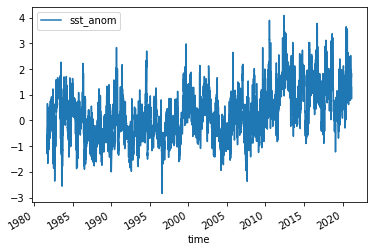

In [7]:
new_ts[0].plot("time", "sst_anom")

## Step 5: Export

In [8]:
# Information Constants

# Timeseries destination folder
out_folder   = f"{box_root}RES_Data/OISST/oisst_mainstays/regional_timeseries/gmri_sst_focal_areas"

# Anomaly Grid Name
grid_name    = "OISSTv2_anom"


##### Loop through all the areas  ####
for i, area in focal_area_info.iterrows():
    
    # Fix the spaces and other characters in the name
    mask_name = area["area"].replace(" ", "_").replace("-", "_").replace("___", "_").replace("__", "_").lower()  
    
    # Path to the timeseries
    out_path = f"{out_folder}/{grid_name}_{mask_name}.csv"
    
    # And export
    new_ts[i].to_csv(out_path, index = False)